# Exploratory Data Analysis

The goal of this JuPyter notebook is to explore and analyze various possible features for the Quora Insincere Question challenge hosted on Kaggle.  The challenge aims to classify questions into 0 (sincere) and 1 (insincere) questions to better flag insincere questions asked on the website.  The challenge can be found here: https://www.kaggle.com/c/quora-insincere-questions-classification .

## Imports

We start by importing useful libraries and the dataset itself.  Since we are looking at questions asked on Quora, there will naturally be a lot of Natural Language Processing libraries here from NLTK and spaCy.

In [111]:
# import useful stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import string
from collections import Counter

# track progress
from tqdm import tqdm

# NLTK
# vader sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# spaCy lacks collocations, so we'll make use of NLTK
from nltk.collocations import *
nltk.download("punkt")

# spaCy
import spacy
import plac
from spacy.attrs import ORTH
import io
from spacy.lang.en.stop_words import STOP_WORDS

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AFKsi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The "train.csv" file is imported below.  Since we are doing an EDA, we don't have to worry about the "test.csv" file.  Espcially considering that there are no targets assigned in that file anyway.

In [2]:
# get files
train = pd.read_csv("train.csv")
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Minor Cleanup

We can drop the "qid" column because we know that will never contribute anything to the model.  This also makes the dataset smaller and more compact to work with.

In [3]:
# drop the qid column, we already know this contributes absolutely nothing to us here
train.drop("qid", axis = 1, inplace = True)
train.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


And we check for any missing data that we might want to take a look at before the analysis itself.

In [5]:
# missing data check
train.apply(lambda x: sum(x.isnull()), axis=0)

question_text    0
target           0
dtype: int64

## Distributions

We start by taking a quick look at the distribution of the targets in the dataset.  This gives us an idea at what we are looking at.

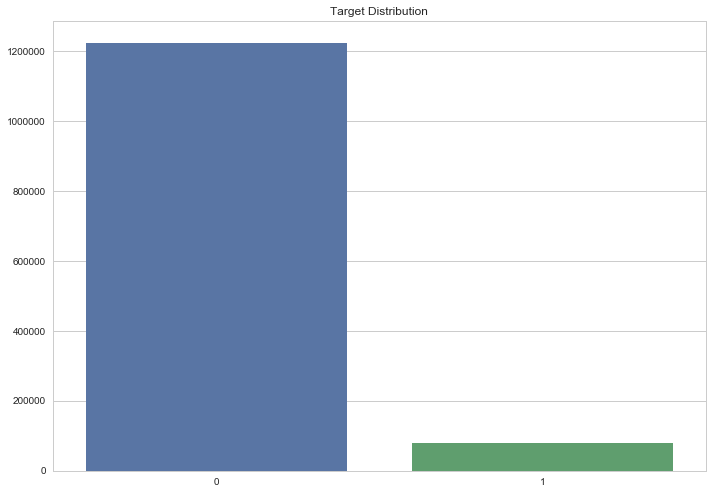

In [108]:
# target distribution as whole numbers
# set the seaborn style
sns.set(style = "whitegrid", rc = {"figure.figsize":(11.7, 8.27)})

# count of targets
target_count = train["target"].value_counts()

# barplot of distribution
ax = sns.barplot(x = target_count.index, y = target_count.values, data = train).set_title("Target Distribution")

In [6]:
# easy to read statement
print("There are", target_count[0], "sincere questions and", target_count[1], "insincere questions in the training dataset.")

There are 1225312 sincere questions and 80810 insincere questions in the training dataset.


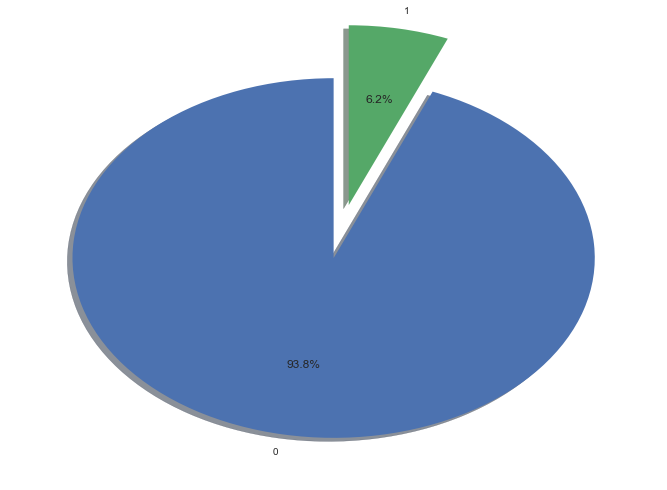

<Figure size 842.4x595.44 with 0 Axes>

In [10]:
# matplotlib because seaborn doesn't have a piechart option :(
labels = ["0", "1"]
values = [target_count[0], target_count[1]]
explode = (0, 0.3)

ax1 = plt.pie(values, labels = labels, explode = explode, shadow = True, startangle = 90, autopct = "%.1f%%")
figure(figsize = (11.7, 8.27))

plt.show()

Amusingly, if we took the test dataset and simply said everything was 0, we would possibly classify >90% of the questions correctly.  But that would defeat the purpose of the challenge.

## Some Statistics

We can take a look at some additional statistics.  For example, how many characters are in each question, how many words and what's the average length of each word.

First, we take a look at the number of characters in each question.

In [68]:
# lengths of questions in characters
train["characters"] = train["question_text"].str.len()
train.head()

,question_text,target,bigrams,characters
0,How did Quebec nationalists see their province...,0,"[How Quebec, Quebec nationalists, nationalists...",72
1,"Do you have an adopted dog, how would you enco...",0,"[Do adopted, adopted dog, dog encourage, encou...",81
2,Why does velocity affect time? Does velocity a...,0,"[Why velocity, velocity affect, affect time, t...",67
3,How did Otto von Guericke used the Magdeburg h...,0,"[How Otto, Otto von, von Guericke, Guericke Ma...",57
4,Can I convert montra helicon D to a mountain b...,0,"[Can I, I convert, convert montra, montra heli...",77


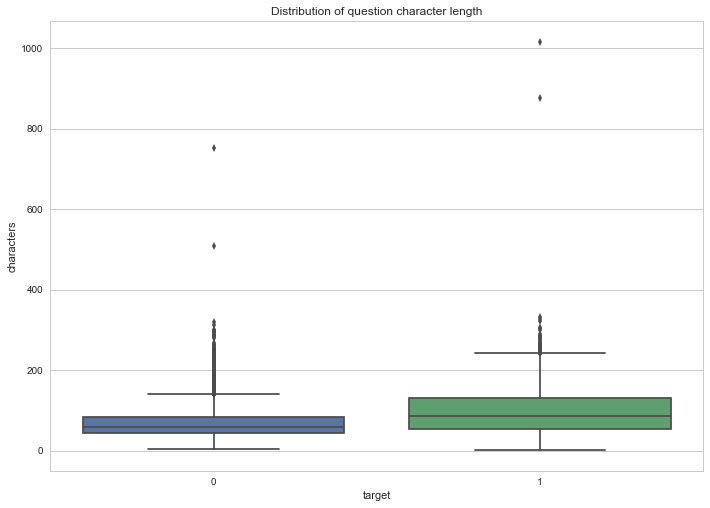

In [69]:
# graph the above
ax = sns.boxplot(x = "target", y = "characters", data = train).set_title("Distribution of question character length")

In [77]:
# statements
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

print("The average question has", round(sum(train["characters"])/len(train["characters"]), 1), "characters.")
print("The average sincere question has", round(sum(train_0["characters"])/len(train_0["characters"]), 1), "characters.")
print("The average insincere question has", round(sum(train_1["characters"])/len(train_1["characters"]), 1), "characters.")

The average question has 70.7 characters.
The average sincere question has 68.9 characters.
The average insincere question has 98.1 characters.


We can see that there is quite the difference in characters between sincere and insincere questions, an about 42% increase in character length!

Next, we can see how many words there are per question.

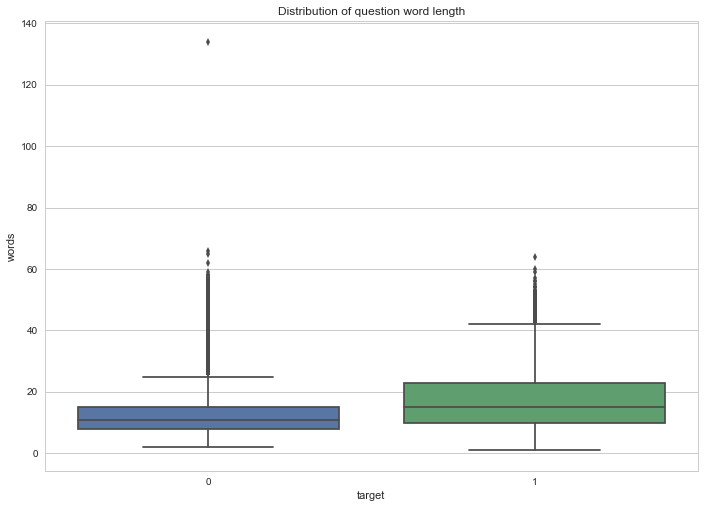

In [70]:
# count number of words
train["words"] = train["question_text"].str.split().str.len()

# graphing
ax = sns.boxplot(x = "target", y = "words", data = train).set_title("Distribution of question word length")

In [78]:
# statements
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

print("The average question has", round(sum(train["words"])/len(train["words"]), 1), "words.")
print("The average sincere question has", round(sum(train_0["words"])/len(train_0["words"]), 1), "words.")
print("The average insincere question has", round(sum(train_1["words"])/len(train_1["words"]), 1), "words.")

The average question has 12.8 words.
The average sincere question has 12.5 words.
The average insincere question has 17.3 words.


Again, a pretty decent sized difference at a 38% increase.  Looks like insincere question askers have a lot to say.

What about the average word length?

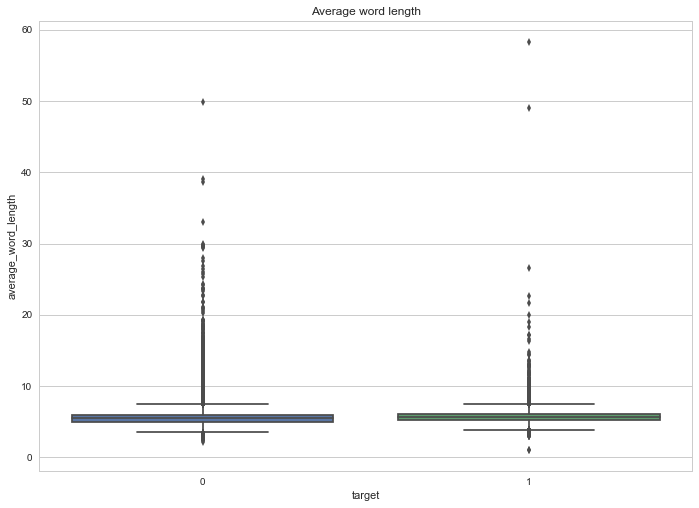

In [79]:
# average word length
train["average_word_length"] = train["question_text"].replace(" ","").str.len()/train["words"]

ax = sns.boxplot(x = "target", y = "average_word_length", data = train).set_title("Average word length")

In [80]:
# statements
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

print("The average question has", round(sum(train["average_word_length"])/len(train["average_word_length"]), 1), 
     "character long words.")
print("The average sincere question has", round(sum(train_0["average_word_length"])/len(train_0["average_word_length"]), 1),
      "character long words.")
print("The average insincere question has", 
      round(sum(train_1["average_word_length"])/len(train_1["average_word_length"]), 1), "words.")

The average question has 5.6 character long words.
The average sincere question has 5.6 character long words.
The average insincere question has 5.7 words.


In this case, not much of a difference.  Sincere and insincere question askers use about the same word lengths.  Only a 1.8% increase in word length by insincere askers.

In [86]:
# garbage
train.drop(["characters", "words", "average_word_length"], axis = 1, inplace = True)

## Sentiment Analysis

One thing I've wondered about is whether there is a difference in sentiment between insincerely asked questions and sincerely asked ones.  For example, imagine someone asking "Why are Jews so evil?" which would have a negative sentiment versus a relatively neutral sentiment from a question such as "Who came up with the Heliocentrism idea?"

To analyze this, we make use of the Vader Sentiment Analyzer found in the NLTK library.

In [44]:
# insincere questions have a certain tone to them that is different from sincere questions
# can we make a useful feature out of this?
analyzer = SentimentIntensityAnalyzer()

# create a function to iterate over the whole dataset
def question_sentiment(question):
    result = analyzer.polarity_scores(question)
    score = result["compound"]
    return round(score, 2)

In [65]:
# example to check things
example = train["question_text"][1234]
example_target = train["target"][1234]
print(example)
print("Sentiment of the example:", question_sentiment(example))
print("Target:", example_target)

Why does everyone assume the NFL kneelers have a right to free speech? That right is not protected by employees from employers by 1st amendment.
Sentiment of the example: 0.22
Target: 1


In [67]:
# iterate over the whole dataset to produce another column of values
train["sentiment_value"] = train["question_text"].apply(question_sentiment)
train.head()

,question_text,target,sentiment_value
0,How did Quebec nationalists see their province...,0,0.00
1,"Do you have an adopted dog, how would you enco...",0,0.61
2,Why does velocity affect time? Does velocity a...,0,0.00
3,How did Otto von Guericke used the Magdeburg h...,0,0.00
4,Can I convert montra helicon D to a mountain b...,0,0.00


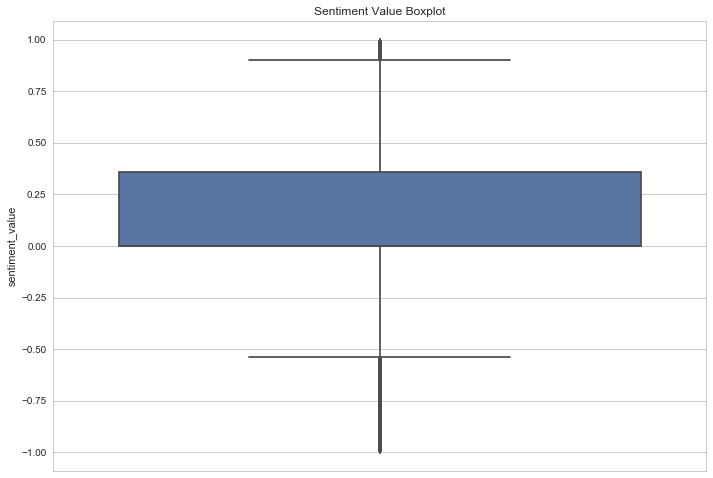

In [71]:
# overall boxplot of sentiments
ax2 = sns.boxplot(y = "sentiment_value", data = train).set_title("Sentiment Value Boxplot")

Overall sentiment appears to be quite neutral, with a large number of outliers.  We should take a look at the sentiment of the different target questions.

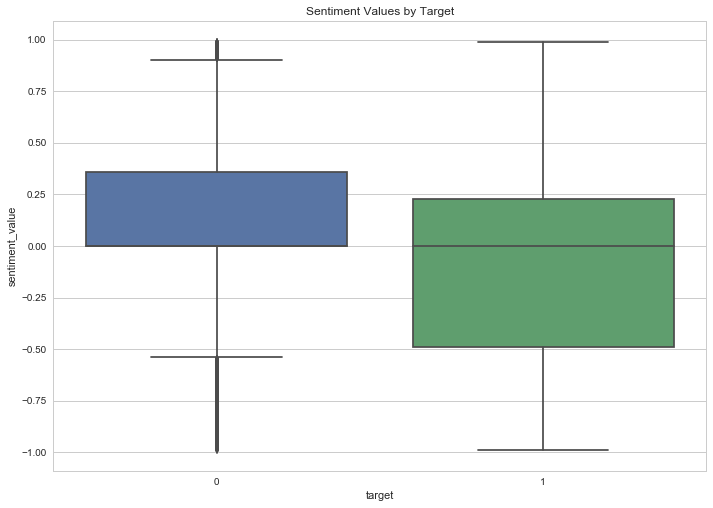

In [72]:
# boxplots by target, is there a difference between them?
ax3 = sns.boxplot(x = "target", y = "sentiment_value", data = train).set_title("Sentiment Values by Target")

The means are about the same, but the interquartile range is bigger for insincere questions and there are fewer outliers as well.  This might not be a big enough difference to include in a model.  On the other hand, the sentiment range of sincere questions is smaller than that of the insincere questions so it might be worth saying that any sentiment value above or below a certain range is more likely to be insincere.

## Text Processing

To further analyze the text of the data, we need to process it by lemmatizing (reduce words to their base form), removing stop words and punctuation.

In [5]:
# load the english module for spacy and disable unnecessary parts of the pipeline
nlp = spacy.load('en_core_web_sm', disable = ["ner"])

# write a function to process the text
def process_text(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text if token.is_stop != True and token.is_punct != True]
    return " ".join(lemmas)

In [6]:
# example
example = train["question_text"][1234]
process_example = process_text(example)
print(example)
print("\n", process_example)

Why does everyone assume the NFL kneelers have a right to free speech? That right is not protected by employees from employers by 1st amendment.

 why assume nfl kneeler right free speech that right protect employee employer 1st amendment


In [7]:
# iterate over the whole column of interest
tqdm.pandas()
lemmatized_question_text = train["question_text"].progress_apply(process_text)

100%|██████████| 1306122/1306122 [2:26:55<00:00, 148.16it/s] 


In [29]:
# take a look at the results
lemmatized_question_text.head()

0          how quebec nationalist province nation 1960
1             do adopt dog encourage people adopt shop
2    why velocity affect time do velocity affect sp...
3           how otto von guericke magdeburg hemisphere
4    can -PRON- convert montra helicon d mountain b...
Name: question_text, dtype: object

In [30]:
# add to the original dataset so we don't forget/lose it somehow...
# also means we don't work on the original lemmatized data, so we won't need to rerun it if we make a mistake down the line
train["lemmatized_text"] = lemmatized_question_text
train.head()

,question_text,target,lemmatized_text
0,How did Quebec nationalists see their province...,0,how quebec nationalist province nation 1960
1,"Do you have an adopted dog, how would you enco...",0,do adopt dog encourage people adopt shop
2,Why does velocity affect time? Does velocity a...,0,why velocity affect time do velocity affect sp...
3,How did Otto von Guericke used the Magdeburg h...,0,how otto von guericke magdeburg hemisphere
4,Can I convert montra helicon D to a mountain b...,0,can -PRON- convert montra helicon d mountain b...


## Individual Word Frequencies

We can use our processed text to determine the most common words in the dataset.

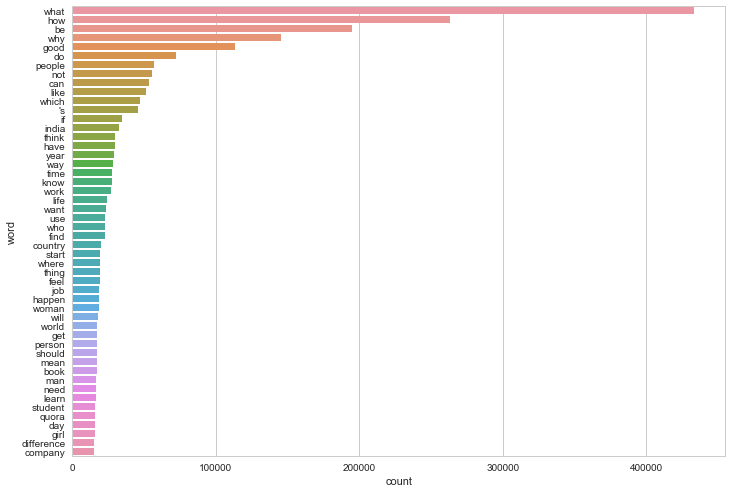

In [32]:
# 50 most common words overall
# 51 because the -PRON- is useless to look at
most_common = Counter(" ".join(train["lemmatized_text"]).split()).most_common(51) 

# convert to dataframe for ease of use
most_common_df = pd.DataFrame(most_common)
most_common_df.columns = ["word", "count"]
most_common_df.drop(most_common_df.index[1], inplace = True) # drop the row with -PRON-

# plot everything
ax4 = sns.barplot(x = "count", y = "word", data = most_common_df)

# garbage
del most_common, most_common_df

Looking at just the overall data doesn't really tell use much, except give us an idea.  Instead, we should divide the data based on their targets and then see what words are common in both.

In [38]:
# should look at the targets individually
# split the dataset into targets 0 and 1
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

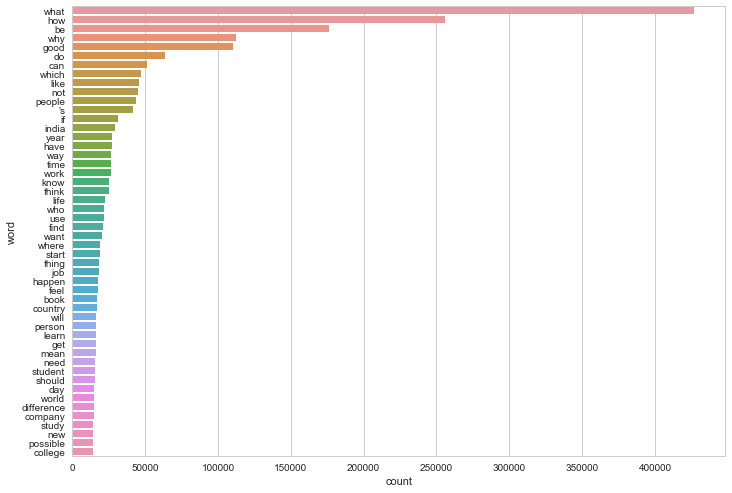

In [36]:
# most common words in train_0
most_common_0 = Counter(" ".join(train_0["lemmatized_text"]).split()).most_common(51)

# convert to dataframe for ease of use
most_common_0_df = pd.DataFrame(most_common_0)
most_common_0_df.columns = ["word", "count"]
most_common_0_df.drop(most_common_0_df.index[1], inplace = True) # drop the row with -PRON-

# plot everything
ax5 = sns.barplot(x = "count", y = "word", data = most_common_0_df)

# garbage
del most_common_0, most_common_0_df

Lots of questionng words such as "what", "how" and "why".  What about insincere questions?

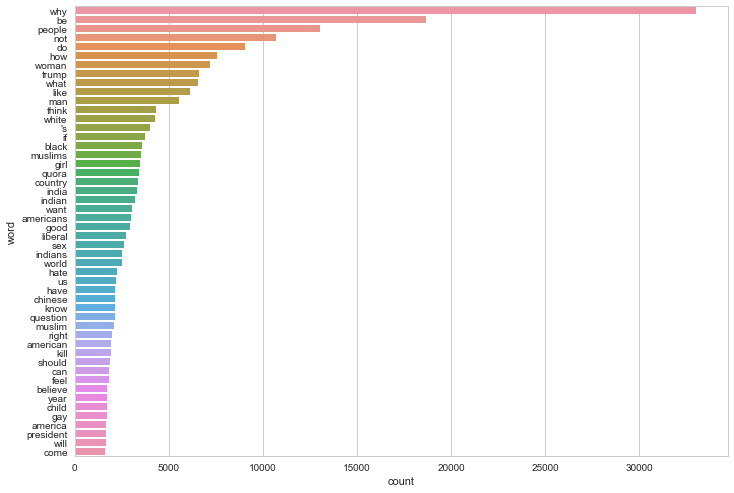

In [39]:
# most common words in train_1
most_common_1 = Counter(" ".join(train_1["lemmatized_text"]).split()).most_common(51)

# convert to dataframe for ease of use
most_common_1_df = pd.DataFrame(most_common_1)
most_common_1_df.columns = ["word", "count"]
most_common_1_df.drop(most_common_1_df.index[2], inplace = True) # drop the row with -PRON-

# plot everything
ax6 = sns.barplot(x = "count", y = "word", data = most_common_1_df)

# garbage
del most_common_1, most_common_1_df

Notice the kinds of words that pop up in insincere questions in comparison?  Like race, Trump and sexual orientation.

## Noun Frequencies

Nouns might be better to see what are topics in common with sincere and insincere questions.  So we want to take our processed text and retrieve nouns from it.

In [24]:
# function to reduce the processed text to just nouns
def find_nouns(text):
    text = nlp(text)
    nouns = [token.text for token in text if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]
    return " ".join(nouns)

In [25]:
# testing testing 1 2 3
example = find_nouns(train["question_text"][1234])
example

'nfl speech employee employer 1st amendment'

In [26]:
# apply to the dataset
tqdm.pandas()
nouns_text = train["question_text"].progress_apply(find_nouns)

100%|██████████| 1306122/1306122 [1:58:37<00:00, 183.52it/s] 


In [27]:
# checking
nouns_text.head()

0                       quebec province nation
1                    dog encourage people shop
2        velocity time velocity space geometry
3            guericke use magdeburg hemisphere
4    convert helicon mountain bike change tyre
Name: lemmatized_text, dtype: object

In [28]:
# combine to train
train["nouns_text"] = nouns_text

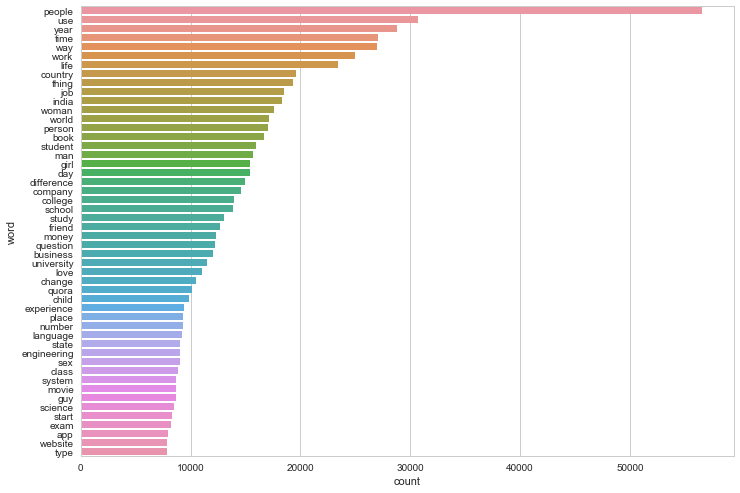

In [32]:
# overall noun frequency graph
common_nouns = Counter(" ".join(train["nouns_text"]).split()).most_common(51)

# convert to dataframe for ease of use
common_nouns_df = pd.DataFrame(common_nouns)
common_nouns_df.columns = ["word", "count"]
common_nouns_df.drop(common_nouns_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax7 = sns.barplot(x = "count", y = "word", data = common_nouns_df)

# garbage
del common_nouns, common_nouns_df

In [ ]:
# split by targets
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

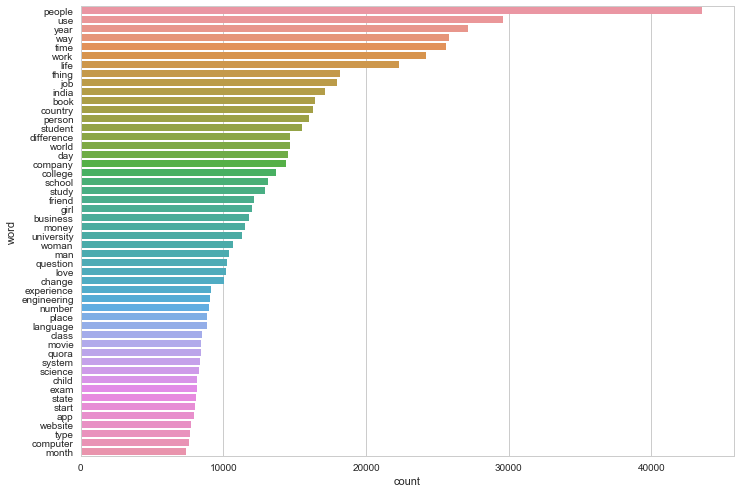

In [35]:
# target 0 nouns
common_nouns_0 = Counter(" ".join(train_0["nouns_text"]).split()).most_common(51)

# convert to dataframe for ease of use
common_nouns_0_df = pd.DataFrame(common_nouns_0)
common_nouns_0_df.columns = ["word", "count"]
common_nouns_0_df.drop(common_nouns_0_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax8 = sns.barplot(x = "count", y = "word", data = common_nouns_0_df)

# garbage
del common_nouns_0_df, train_0

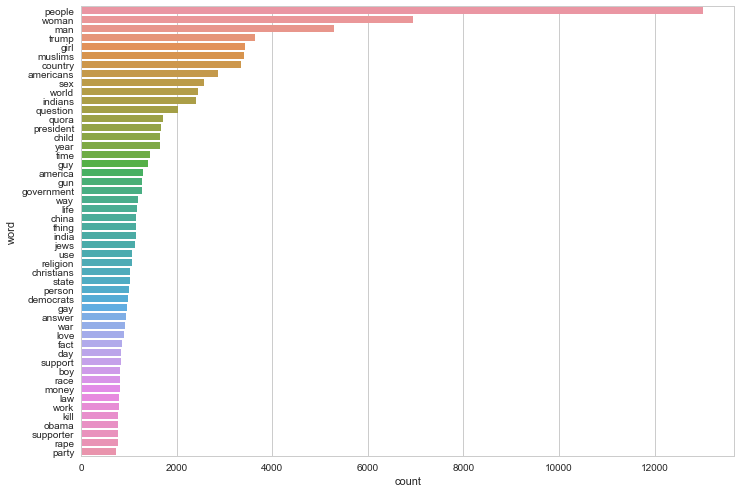

In [39]:
# target 1 nouns
common_nouns_1 = Counter(" ".join(train_1["nouns_text"]).split()).most_common(51)

# convert to dataframe for ease of use
common_nouns_1_df = pd.DataFrame(common_nouns_1)
common_nouns_1_df.columns = ["word", "count"]
common_nouns_1_df.drop(common_nouns_1_df.index[2], inplace = True) # drop the row with -PRON-

# plot everything
ax9 = sns.barplot(x = "count", y = "word", data = common_nouns_1_df)

# garbage
del common_nouns_1_df, train_1

We can see that insincere questions have a lot of topics related to politics and religion (the noun is even in there!).  This might be useful for us to model later since clearly these kinds of words point more towards an insincere question.

## Bigram Frequencies

Looking at 2-word phrases might yield a better idea of what is found in the dataset.  Bigrams can help us to see what askers associate different topics/words with.

In [50]:
# write a function for processing text to give bigrams
# spaCy for text processing, NLTK for collocations
def find_bigrams(text):
    text = nlp(text)
    tokens = [token.text for token in text if token.is_punct != True and token.is_stop != True]
    ngrams = zip(*[tokens[i:] for i in range(2)])
    return [" ".join(ngram) for ngram in ngrams]

In [52]:
# testing
example = train["question_text"][1234]
x = find_bigrams(example)
print(x)

['Why assume', 'assume NFL', 'NFL kneelers', 'kneelers right', 'right free', 'free speech', 'speech That', 'That right', 'right protected', 'protected employees', 'employees employers', 'employers 1st', '1st amendment']


In [53]:
# iterate over the dataset
tqdm.pandas()
bigrams_found = train["question_text"].progress_apply(find_bigrams)

100%|██████████| 1306122/1306122 [2:13:01<00:00, 163.65it/s] 


In [54]:
# see what everything looks like
bigrams_found.head()

0    [How Quebec, Quebec nationalists, nationalists...
1    [Do adopted, adopted dog, dog encourage, encou...
2    [Why velocity, velocity affect, affect time, t...
3    [How Otto, Otto von, von Guericke, Guericke Ma...
4    [Can I, I convert, convert montra, montra heli...
Name: question_text, dtype: object

In [123]:
# make a dataframe
train["bigrams"] = bigrams_found
train.head()

,question_text,target,bigrams
0,How did Quebec nationalists see their province...,0,"[How Quebec, Quebec nationalists, nationalists..."
1,"Do you have an adopted dog, how would you enco...",0,"[Do adopted, adopted dog, dog encourage, encou..."
2,Why does velocity affect time? Does velocity a...,0,"[Why velocity, velocity affect, affect time, t..."
3,How did Otto von Guericke used the Magdeburg h...,0,"[How Otto, Otto von, von Guericke, Guericke Ma..."
4,Can I convert montra helicon D to a mountain b...,0,"[Can I, I convert, convert montra, montra heli..."


In [101]:
# extract all bigrams into a giant list (rip ram)
all_bigrams = train["bigrams"].tolist()

# flatten it
all_bigrams = [item for sublist in all_bigrams for item in sublist]

# checking
all_bigrams[:10]

['How Quebec',
 'Quebec nationalists',
 'nationalists province',
 'province nation',
 'nation 1960s',
 'Do adopted',
 'adopted dog',
 'dog encourage',
 'encourage people',
 'people adopt']

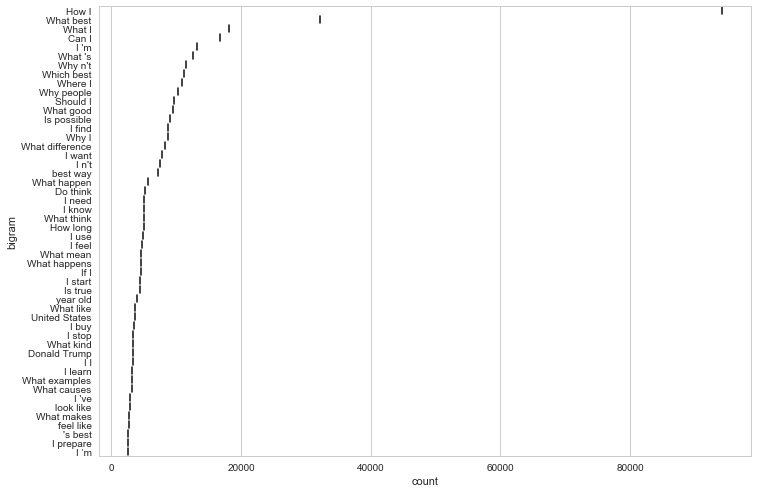

In [109]:
# find the most common bigrams
common_bigrams = Counter(all_bigrams).most_common(50)

# dataframe stuff
common_bigrams_df = pd.DataFrame(common_bigrams)
common_bigrams_df.columns = ["bigram", "count"]

# graphing time
ax = sns.boxplot(x = "count", y = "bigram", data = common_bigrams_df)

#garbage
del common_bigrams_df

In [112]:
# split by targets
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

In [114]:
# extract all bigrams into a giant list (rip ram)
all_bigrams_0 = train_0["bigrams"].tolist()

# flatten it
all_bigrams_0 = [item for sublist in all_bigrams_0 for item in sublist]

# checking
all_bigrams_0[:10]

['How Quebec',
 'Quebec nationalists',
 'nationalists province',
 'province nation',
 'nation 1960s',
 'Do adopted',
 'adopted dog',
 'dog encourage',
 'encourage people',
 'people adopt']

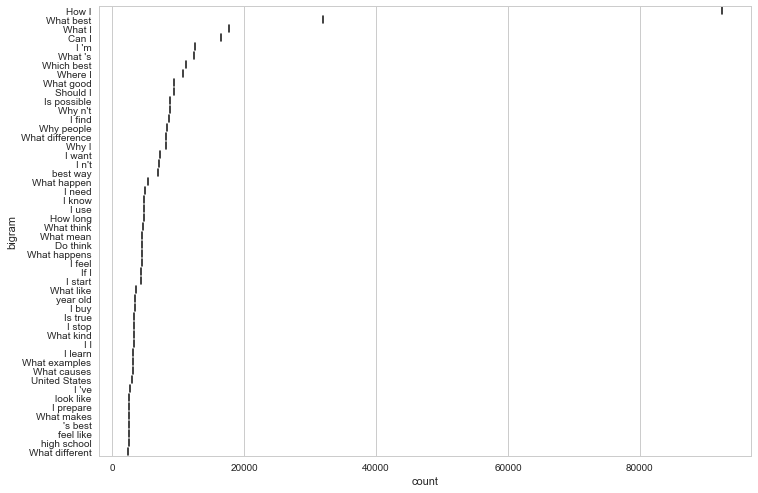

In [120]:
# find the most common bigrams
common_bigrams_0 = Counter(all_bigrams_0).most_common(50)

# dataframe stuff
common_bigrams_0_df = pd.DataFrame(common_bigrams_0)
common_bigrams_0_df.columns = ["bigram", "count"]

# graphing time
ax = sns.boxplot(x = "count", y = "bigram", data = common_bigrams_0_df)

#garbage
del common_bigrams_0_df, common_bigrams_0

In [117]:
# extract all bigrams into a giant list (rip ram)
all_bigrams_1 = train_1["bigrams"].tolist()

# flatten it
all_bigrams_1 = [item for sublist in all_bigrams_1 for item in sublist]

# checking
all_bigrams_1[:10]

['Has United',
 'United States',
 'States largest',
 'largest dictatorship',
 'dictatorship world',
 'Which babies',
 'babies sweeter',
 'sweeter parents',
 'parents Dark',
 'Dark skin']

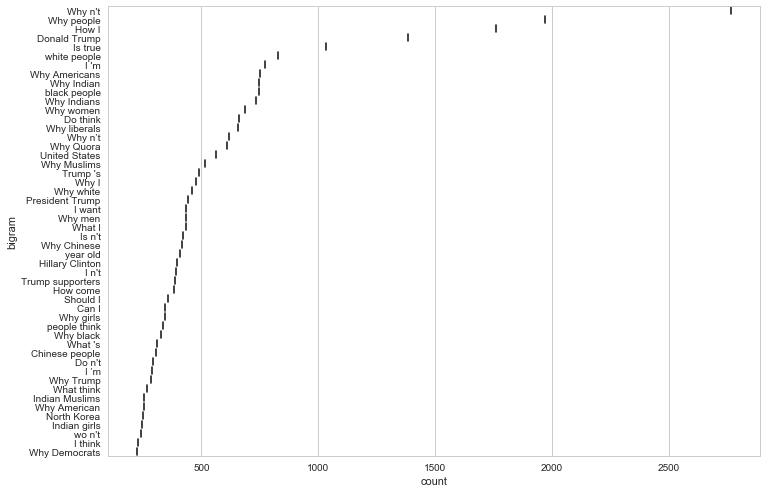

In [121]:
# find the most common bigrams
common_bigrams_1 = Counter(all_bigrams_1).most_common(50)

# dataframe stuff
common_bigrams_1_df = pd.DataFrame(common_bigrams_1)
common_bigrams_1_df.columns = ["bigram", "count"]

# graphing time
ax = sns.boxplot(x = "count", y = "bigram", data = common_bigrams_1_df)

#garbage
del common_bigrams_1_df, common_bigrams_1

Sincere questions have a lot of questioning bigrams, such as "How I" and "What best".  In comparison, insincere questions have plenty of "President Trump" and "Why black".  

In [124]:
# garbage
train.drop("bigrams", axis = 1, inplace = True)

## Trigram Frequencies

3-word associations can possibly give us an even better idea.  Higher than this and we will likely get very sparse results or may as well categorize the questions themselves.

In [58]:
def find_trigrams(text):
    text = nlp(text)
    tokens = [token.text for token in text if token.is_punct != True and token.is_stop != True]
    ngrams = zip(*[tokens[i:] for i in range(3)])
    return [" ".join(ngram) for ngram in ngrams]

In [59]:
# testing
example = train["question_text"][1234]
x = find_trigrams(example)
print(x)

['Why assume NFL', 'assume NFL kneelers', 'NFL kneelers right', 'kneelers right free', 'right free speech', 'free speech That', 'speech That right', 'That right protected', 'right protected employees', 'protected employees employers', 'employees employers 1st', 'employers 1st amendment']


In [60]:
# iterate over the dataset
tqdm.pandas()
trigrams_found = train["question_text"].progress_apply(find_trigrams)

100%|██████████| 1306122/1306122 [2:29:49<00:00, 145.30it/s] 


In [89]:
# see what was produced
trigrams_found.head()

0    [How Quebec nationalists, Quebec nationalists ...
1    [Do adopted dog, adopted dog encourage, dog en...
2    [Why velocity affect, velocity affect time, af...
3    [How Otto von, Otto von Guericke, von Guericke...
4    [Can I convert, I convert montra, convert mont...
Name: question_text, dtype: object

In [125]:
train["trigrams"] = trigrams_found
train.head()

,question_text,target,trigrams
0,How did Quebec nationalists see their province...,0,"[How Quebec nationalists, Quebec nationalists ..."
1,"Do you have an adopted dog, how would you enco...",0,"[Do adopted dog, adopted dog encourage, dog en..."
2,Why does velocity affect time? Does velocity a...,0,"[Why velocity affect, velocity affect time, af..."
3,How did Otto von Guericke used the Magdeburg h...,0,"[How Otto von, Otto von Guericke, von Guericke..."
4,Can I convert montra helicon D to a mountain b...,0,"[Can I convert, I convert montra, convert mont..."


In [126]:
# extract all trigrams
all_trigrams = train["trigrams"].tolist()

# flatten it
all_trigrams = [item for sublist in all_trigrams for item in sublist]

# checking
all_trigrams[:10]

['How Quebec nationalists',
 'Quebec nationalists province',
 'nationalists province nation',
 'province nation 1960s',
 'Do adopted dog',
 'adopted dog encourage',
 'dog encourage people',
 'encourage people adopt',
 'people adopt shop',
 'Why velocity affect']

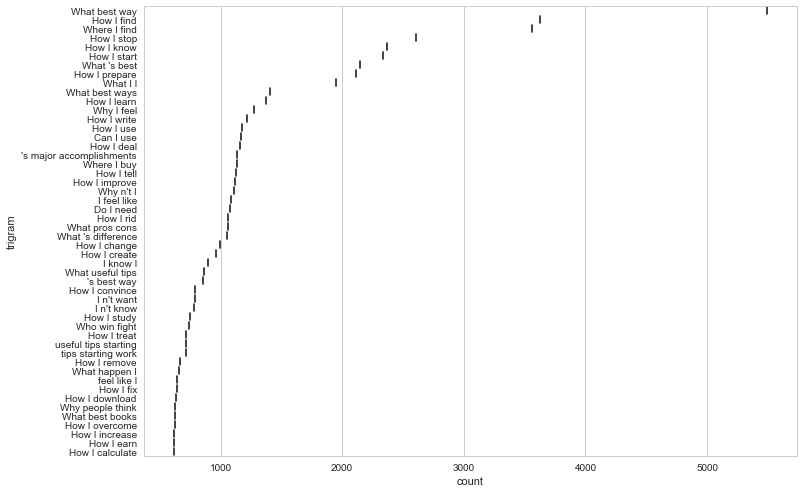

In [127]:
# find the most common trigrams
common_trigrams = Counter(all_trigrams).most_common(50)

# dataframe stuff
common_trigrams_df = pd.DataFrame(common_trigrams)
common_trigrams_df.columns = ["trigram", "count"]

# graphing time
ax = sns.boxplot(x = "count", y = "trigram", data = common_trigrams_df)

#garbage
del common_trigrams_df

In [128]:
# split by targets
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

In [129]:
# extract all trigrams
all_trigrams_0 = train_0["trigrams"].tolist()

# flatten it
all_trigrams_0 = [item for sublist in all_trigrams_0 for item in sublist]

# checking
all_trigrams_0[:10]

['How Quebec nationalists',
 'Quebec nationalists province',
 'nationalists province nation',
 'province nation 1960s',
 'Do adopted dog',
 'adopted dog encourage',
 'dog encourage people',
 'encourage people adopt',
 'people adopt shop',
 'Why velocity affect']

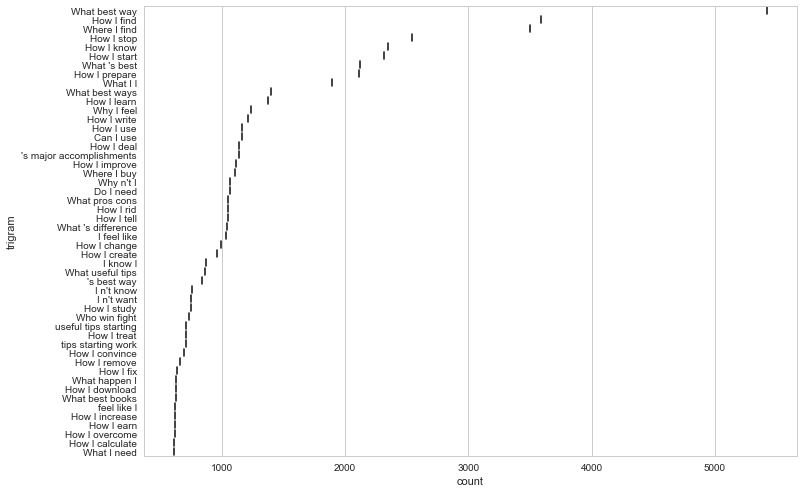

In [130]:
# find the most common trigrams
common_trigrams_0 = Counter(all_trigrams_0).most_common(50)

# dataframe stuff
common_trigrams_0_df = pd.DataFrame(common_trigrams_0)
common_trigrams_0_df.columns = ["trigram", "count"]

# graphing time
ax = sns.boxplot(x = "count", y = "trigram", data = common_trigrams_0_df)

# garbage
del common_trigrams_0_df, common_trigrams_0

In [131]:
# extract all trigrams
all_trigrams_1 = train_1["trigrams"].tolist()

# flatten it
all_trigrams_1 = [item for sublist in all_trigrams_1 for item in sublist]

# checking
all_trigrams_1[:10]

['Has United States',
 'United States largest',
 'States largest dictatorship',
 'largest dictatorship world',
 'Which babies sweeter',
 'babies sweeter parents',
 'sweeter parents Dark',
 'parents Dark skin',
 'Dark skin babies',
 'skin babies light']

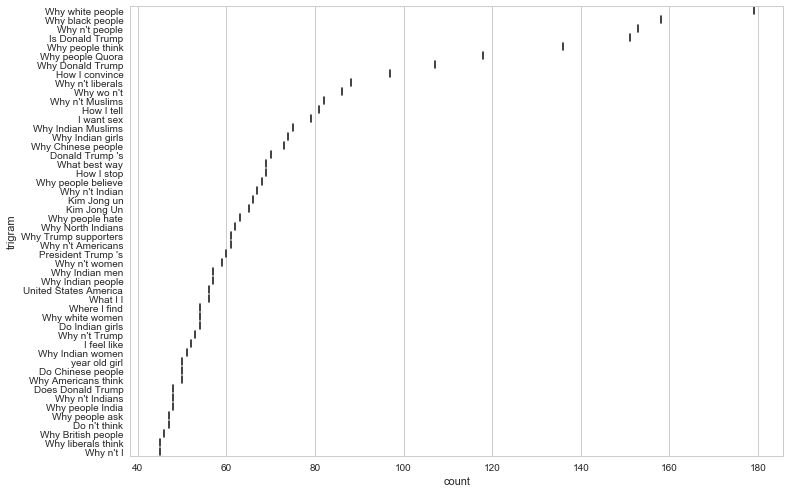

In [132]:
# find the most common trigrams
common_trigrams_1 = Counter(all_trigrams_1).most_common(50)

# dataframe stuff
common_trigrams_1_df = pd.DataFrame(common_trigrams_1)
common_trigrams_1_df.columns = ["trigram", "count"]

# graphing time
ax = sns.boxplot(x = "count", y = "trigram", data = common_trigrams_1_df)

# garbage
del common_trigrams_1_df, common_trigrams_1

Again, sincere questions have plenty of questioning trigrams whereas insincere questions continue to follow the trend of lots of topics in them.

In [133]:
# garbage
train.drop("trigrams", axis = 1, inplace = True)

## Conclusions

With this, we have a nice starting point for modelling the data to try to classify sincere and insincere questions.  More features might pop up as modelling goes along so this is by no means exhaustive on what features might be useful to us.